با سلام تمرین شما تصحیح شد.مدلتون باز هم جا داره تا آموزشش رو کامل کنه. تعداد ایپاک ها را بیشتر کنید و همچنین ظرفیت مدل رو هم می تونین افزایش بدید. لطفا فایل  پیش بینی هم برای داده های تست رو ارسال کنید تا دقت مدلتون رو محاسبه کنم..با تشکر

### Sayed Mahdi Mousavi

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Section 0: Imports and Install📢**

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [ ]:
torch.manual_seed(59)

# **Section 1: Load Dataset📑**

In [ ]:
!cp /content/drive/MyDrive/Datasets/exercises_3_DL/train.csv /content
!cp /content/drive/MyDrive/Datasets/exercises_3_DL/test.csv /content

# or

# !cp /content/drive/MyDrive/Datasets/exercises_3_DL/dataset.rar /content
# !unzip /content/dataset.rar

## 1-1: Read Dataset

In [ ]:
data = pd.read_csv(r'/content/train.csv')

##1-2: Train_Test_Split

In [ ]:
# method 1
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


##1-3: Preprocess

In [ ]:
# convert to tensor
x_train = torch.FloatTensor(x_train.values)
x_valid = torch.FloatTensor(x_valid.values)

y_valid = torch.FloatTensor(y_valid.values)
y_train = torch.FloatTensor(y_train.values)


# Standardization
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## 1-4: Dataloader

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

#**Section2: Define Model🧠**

##2-1: make your MLP Model

In [ ]:
in_features = 12
out_features = 1
h1 = 32
h2 = 24

model = nn.Sequential(nn.Linear(in_features, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, out_features),
                      nn.Sigmoid())


##2-2: Loss and Optimizer

In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

##2-3: Bias for last layer(before train)

In [ ]:
for name, params in model.named_parameters():
    if name == '4.bias':
        print(params)

Parameter containing:
tensor([0.1849], requires_grad=True)


#**Section3: Device⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!nvidia-smi

Wed Feb 22 09:21:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#**Section4: Train Model🤓**

##4-1:Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

##4-1:Train Loop

In [ ]:
model = model.to(device)

num_epochs = 500

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

since = time.time()
for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task='binary').to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    
    loss = loss_fn(outputs.squeeze(), targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs.squeeze(), targets)

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(), targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs.squeeze(), targets)

  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(acc_train.compute().item())
  acc_valid_hist.append(acc_valid.compute().item())

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}')
    print(f'Train: Loss = {loss_train.avg:.2}, Acc = {acc_train.compute():.2}')
    print(f'Valid: Loss = {loss_valid.avg:.2}, Acc = {acc_valid.compute():.2}')
    print()


time_elapsed = time.time() - since
print(time_elapsed)

Epoch: 0
Train: Loss = 0.74, Acc = 0.32
Valid: Loss = 0.72, Acc = 0.32

Epoch: 10
Train: Loss = 0.69, Acc = 0.57
Valid: Loss = 0.67, Acc = 0.62

Epoch: 20
Train: Loss = 0.65, Acc = 0.68
Valid: Loss = 0.64, Acc = 0.7

Epoch: 30
Train: Loss = 0.63, Acc = 0.68
Valid: Loss = 0.61, Acc = 0.7

Epoch: 40
Train: Loss = 0.61, Acc = 0.68
Valid: Loss = 0.59, Acc = 0.7

Epoch: 50
Train: Loss = 0.59, Acc = 0.68
Valid: Loss = 0.58, Acc = 0.7

Epoch: 60
Train: Loss = 0.58, Acc = 0.68
Valid: Loss = 0.56, Acc = 0.7

Epoch: 70
Train: Loss = 0.57, Acc = 0.68
Valid: Loss = 0.55, Acc = 0.7

Epoch: 80
Train: Loss = 0.56, Acc = 0.68
Valid: Loss = 0.54, Acc = 0.7

Epoch: 90
Train: Loss = 0.55, Acc = 0.68
Valid: Loss = 0.53, Acc = 0.7

Epoch: 100
Train: Loss = 0.54, Acc = 0.68
Valid: Loss = 0.52, Acc = 0.7

Epoch: 110
Train: Loss = 0.53, Acc = 0.68
Valid: Loss = 0.5, Acc = 0.7

Epoch: 120
Train: Loss = 0.52, Acc = 0.68
Valid: Loss = 0.49, Acc = 0.7

Epoch: 130
Train: Loss = 0.51, Acc = 0.68
Valid: Loss = 0.48,

#**Section5:Result📈**

##5-1:Plot loss and acc

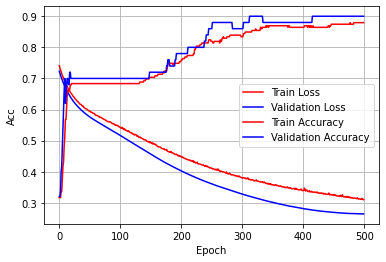

In [ ]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train Loss')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation Loss')
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train Accuracy')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## plot loss_epoch

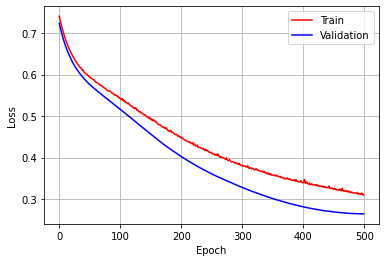

In [ ]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

##plot acc_epoch

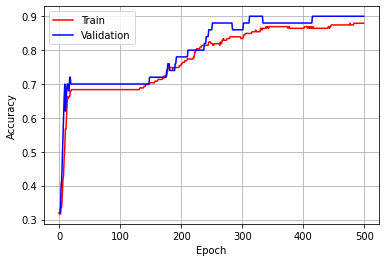

In [ ]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

##5-2:Count param

In [ ]:
count_parameters = torch.tensor([torch.numel(params) for params in model.parameters()])

print(f'Number of parameters in each layer: {count_parameters} --- Total parameters: {count_parameters.sum()}')

Number of parameters in each layer: tensor([384,  32, 768,  24,  24,   1]) --- Total parameters: 1233


##5-3: Bias for last layer(after train)

In [ ]:
for name, params in model.named_parameters():
    if name == '4.bias':
        print(params)


""" 

Bias for last layer(before train): [0.1849]

Bias for last layer(after train): [0.5390]

"""

Parameter containing:
tensor([0.5390], device='cuda:0', requires_grad=True)


#**Section6: Save and Load Model💰**

##6-1: Save

In [ ]:
torch.save(model, 'model.pth')

##6-2: Load

In [ ]:
mymodel = torch.load('model.pth')
mymodel

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=1, bias=True)
  (5): Sigmoid()
)

#**Section7: Model Prediction🩺**

##7-1: Use test.csv

In [ ]:
data_test = pd.read_csv(r'/content/test.csv')

#convert to tensor
data_test = torch.FloatTensor(data_test.values)

# Standardization
data_test = (data_test - mu) / std


In [ ]:
mymodel.eval()
with torch.no_grad():    
    data_test = data_test.to(device)
    outputs_test_data = mymodel(data_test)

print(outputs_test_data)

tensor([[8.5241e-01],
        [8.8856e-01],
        [6.7861e-01],
        [7.9908e-01],
        [7.8752e-01],
        [4.2926e-01],
        [4.4875e-01],
        [7.0859e-01],
        [7.4243e-01],
        [3.7938e-01],
        [5.8999e-01],
        [2.3835e-01],
        [6.3873e-01],
        [8.2891e-01],
        [6.8937e-01],
        [2.8031e-01],
        [2.0328e-01],
        [4.3835e-03],
        [5.1665e-01],
        [1.2397e-03],
        [1.6279e-02],
        [1.5145e-01],
        [6.3795e-02],
        [9.9053e-02],
        [5.0100e-03],
        [9.1414e-03],
        [2.5532e-02],
        [6.1439e-04],
        [2.2082e-03],
        [2.8708e-01],
        [3.1275e-01],
        [2.9763e-02],
        [1.3601e-01],
        [1.0646e-01],
        [4.7546e-01],
        [1.8151e-01],
        [4.3622e-01],
        [7.3065e-01],
        [8.7688e-01],
        [8.1176e-01],
        [8.4248e-01],
        [8.1780e-01],
        [3.9199e-01],
        [1.5209e-01],
        [8.0668e-01],
        [1

##7-2 Make predictions.csv file

In [ ]:
df_test = [items.item() for idx, items in enumerate(outputs_test_data)]

predictions = pd.DataFrame(df_test, columns = ['preds'])
predictions.to_csv('predictions.csv')

predictions

,preds
0,0.852407
1,0.888557
2,0.678608
3,0.799075
4,0.787519
5,0.429262
6,0.448747
7,0.708588
8,0.742432
9,0.379375
